<a href="https://colab.research.google.com/github/Quaser001/scribbles_ml/blob/main/T1_%2B_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# ==========================
# Block 1: Setup & Libraries
# ==========================

# Mount Google Drive (if dataset stored there)
from google.colab import drive
drive.mount('/content/drive')

# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models

# For visualization
import cv2
from PIL import Image


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# =======================
# Dataset Split & DataLoaders
# =======================

from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import os

# Paths
data_dir = "/content/drive/MyDrive/xAIDataset/T1"   # update path if needed
classes = ["T1_HC", "T1_PD"]

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load full dataset without split
full_dataset = datasets.ImageFolder(root=data_dir, transform=val_test_transform)

# Split indices (70% train, 15% val, 15% test)
indices = np.arange(len(full_dataset))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, stratify=full_dataset.targets, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=np.array(full_dataset.targets)[temp_idx], random_state=42)

# Subsets
train_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=train_transform), train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")
print(f"Test samples:  {len(test_dataset)}")


Train samples: 1449
Val samples:   310
Test samples:  311


In [10]:
# --- Block 2: Dataset Preparation & Splitting ---

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transforms (resize, normalize for ResNet-50)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # ImageNet mean
                         [0.229, 0.224, 0.225])   # ImageNet std
])

# Path to dataset
dataset_dir = "/content/drive/MyDrive/xAIDataset/T1"

# Load dataset without predefined split
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=data_transforms)

# Define split sizes (e.g., 70% train, 15% val, 15% test)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

# Stratified split (preserves class balance)
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

targets = [label for _, label in full_dataset.samples]

# First split train+val and test
train_val_idx, test_idx = train_test_split(
    range(total_size),
    test_size=test_size,
    stratify=targets,
    random_state=42
)

# Split train and val
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=val_size,
    stratify=[targets[i] for i in train_val_idx],
    random_state=42
)

# Create subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Dataset sizes -> Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Dataset sizes -> Train: 1449, Val: 310, Test: 311


In [13]:
# ============================
# Model Setup: ResNet-50 (T1 Only)
# ============================

import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load pretrained ResNet-50
resnet50 = models.resnet50(pretrained=True)

# Freeze all layers initially
for param in resnet50.parameters():
    param.requires_grad = False

# Replace final fully connected layer
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)  # 2 classes: HC vs PD

# Loss and optimizer (for FC layer only at first)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=1e-3)

# ------------------------------
# Optional: unfreeze last few layers if needed
# ------------------------------
def unfreeze_last_layers(model, num_layers=3):
    """
    Unfreezes the last `num_layers` ResNet layers + FC for fine-tuning.
    """
    # Get all children (layers)
    layers = list(model.children())

    # Unfreeze last few conv blocks
    for layer in layers[-(num_layers+1):]:  # +1 to keep FC always trainable
        for param in layer.parameters():
            param.requires_grad = True

    # Update optimizer to include these params
    new_params = [p for p in model.parameters() if p.requires_grad]
    return optim.Adam(new_params, lr=1e-4)  # lower LR for fine-tuning


In [15]:
# ======================
# GPU Check + Model Summary
# ======================

import torch
from torchsummary import summary

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Print model summary (ResNet-50)
summary(model, (3, 224, 224))  # input shape: (channels, H, W)


Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models

# -------------------------------
# 1. Load Pretrained ResNet50
# -------------------------------
model = models.resnet50(pretrained=True)

# Freeze everything first
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # binary classification

# Unfreeze last 2 residual blocks for better adaptation
for name, param in model.named_parameters():
    if "layer4" in name or "layer3" in name or "fc" in name:
        param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# -------------------------------
# 2. Weighted Loss (class imbalance)
# -------------------------------
class_counts = torch.tensor([86, 225], dtype=torch.float32)  # HC, PD
weights = 1.0 / class_counts
weights = weights / weights.sum()  # normalize
weights = weights.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

# -------------------------------
# 3. Optimizer + Scheduler
# -------------------------------
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# -------------------------------
# 4. Training Loop
# -------------------------------
num_epochs = 15
best_val_acc = 0.0

# Lists to store metrics for plotting
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []


for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Append to history
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc.item())


    # Validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    # Append to history
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc.item())


    # Scheduler step
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_mri.pth")
        print("✅ Best model updated!")

print(f"\nTraining complete. Best Validation Accuracy: {best_val_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 Train Loss: 0.4313, Train Acc: 0.7812 Val Loss: 0.6644, Val Acc: 0.8323
✅ Best model updated!
Epoch 2/15 Train Loss: 0.0615, Train Acc: 0.9786 Val Loss: 0.0711, Val Acc: 0.9710
✅ Best model updated!
Epoch 3/15 Train Loss: 0.0530, Train Acc: 0.9834 Val Loss: 0.1228, Val Acc: 0.9742
✅ Best model updated!
Epoch 4/15 Train Loss: 0.0416, Train Acc: 0.9869 Val Loss: 0.1030, Val Acc: 0.9548
Epoch 5/15 Train Loss: 0.0334, Train Acc: 0.9862 Val Loss: 0.0980, Val Acc: 0.9710
Epoch 6/15 Train Loss: 0.0278, Train Acc: 0.9924 Val Loss: 0.0313, Val Acc: 0.9871
✅ Best model updated!
Epoch 7/15 Train Loss: 0.0132, Train Acc: 0.9959 Val Loss: 0.0329, Val Acc: 0.9935
✅ Best model updated!
Epoch 8/15 Train Loss: 0.0078, Train Acc: 0.9986 Val Loss: 0.0131, Val Acc: 0.9968
✅ Best model updated!
Epoch 9/15 Train Loss: 0.0009, Train Acc: 1.0000 Val Loss: 0.0095, Val Acc: 0.9968
Epoch 10/15 Train Loss: 0.0005, Train Acc: 1.0000 Val Loss: 0.0048, Val Acc: 0.9968
Epoch 11/15 Train Loss: 0.0004, Train


✅ Test Accuracy: 0.9871, Test Loss: 0.0636

📊 Classification Report:
              precision    recall  f1-score   support

T1 HC images       1.00      0.95      0.98        86
T1 PD images       0.98      1.00      0.99       225

    accuracy                           0.99       311
   macro avg       0.99      0.98      0.98       311
weighted avg       0.99      0.99      0.99       311



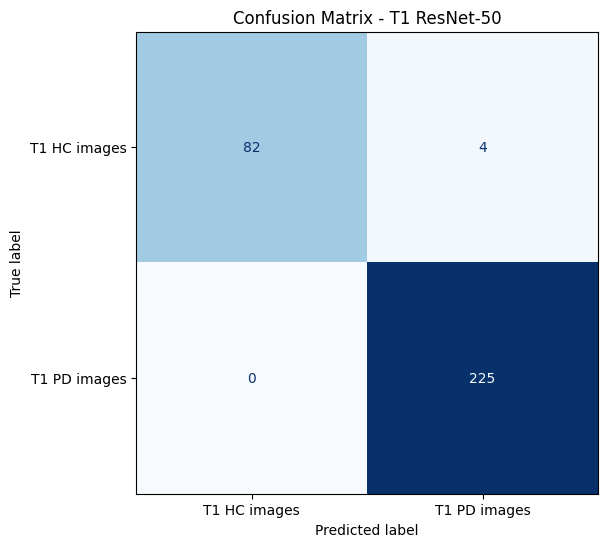

In [21]:
# -----------------------------
# Evaluation & Visualization
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch

# Ensure model is in evaluation mode and on the correct device
model.eval()
model.to(device)

# Evaluate on test set
test_loss = 0.0
correct_predictions = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels) # Use the criterion defined earlier

        test_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(preds.cpu().numpy())


test_loss /= len(test_loader.dataset)
test_acc = correct_predictions.double() / len(test_loader.dataset)

print(f"\n✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Classification Report
# Need to get class names from the dataset
if hasattr(test_dataset, 'dataset') and hasattr(test_dataset.dataset, 'classes'):
    class_labels = test_dataset.dataset.classes
elif hasattr(full_dataset, 'classes'):
     class_labels = full_dataset.classes
else:
     class_labels = [str(i) for i in range(len(set(all_labels)))]
     print("Warning: Could not find class names, using numerical labels.")


print("\n📊 Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d", ax=plt.gca(), colorbar=False)
plt.title("Confusion Matrix - T1 ResNet-50")
plt.show()

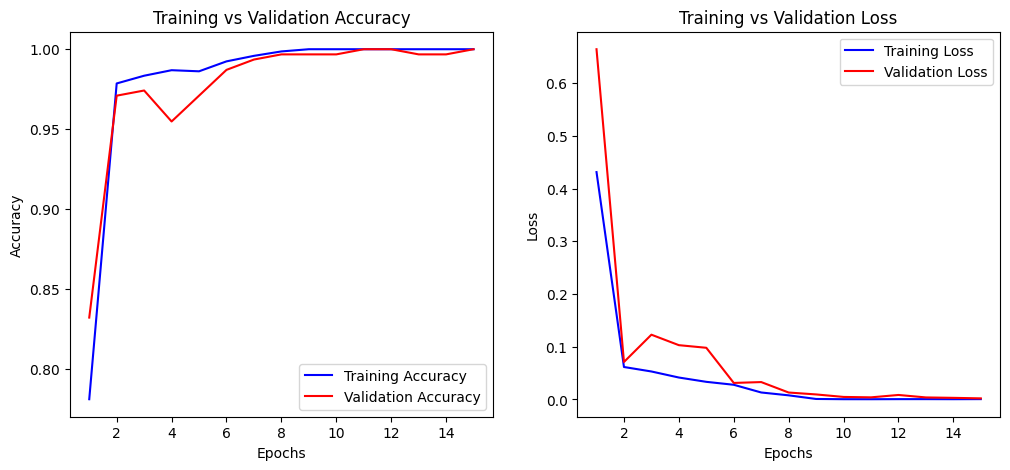

In [24]:
import matplotlib.pyplot as plt

# Use the history lists populated during training
train_acc = train_acc_history
val_acc   = val_acc_history
train_loss = train_loss_history
val_loss   = val_loss_history

epochs = range(1, len(train_acc)+1)

# Plot Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [25]:
import torch

# Suppose your model is called `model`
# And you want to save it to a file called 'resnet_model.pth'

torch.save(model, 'resnet_model.pth')
print("Full model saved successfully!")


Full model saved successfully!


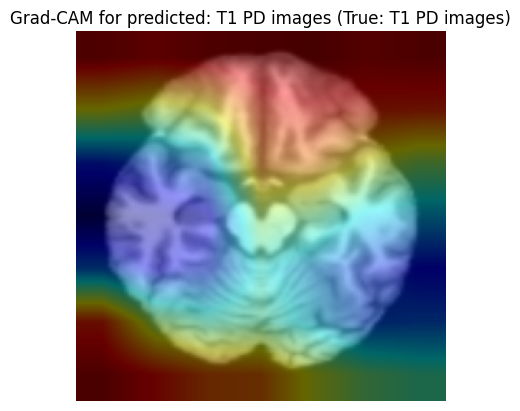

In [32]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Assuming 'model' is your trained ResNet-50 and device is defined
model.eval()
model.to(device)

# Hook to get gradients
gradients = []

def save_gradient(module, grad_input, grad_output):
    # Assuming grad_output is a tuple, we want the gradient of the output
    gradients.append(grad_output[0])

# Choose the last convolutional layer before the average pooling and FC layer
# For ResNet-50, this is typically the last conv layer in layer4
target_layer = model.layer4[-1] # Use the last bottleneck block in layer4

# Register the hook on the target layer's forward pass output to get activations
activations = None
def save_activation(module, input, output):
    global activations
    activations = output.detach()

target_layer.register_forward_hook(save_activation)


# Get a sample image and label from the test loader
dataiter = iter(test_loader)
images, labels = next(dataiter)
sample_image = images[0].unsqueeze(0).to(device)  # Take the first image in the batch and add batch dim, move to device
sample_label = labels[0].item()

# Preprocess the sample image (already done by the test_loader transforms)
# You might need to reverse the normalization for visualization later

# Forward pass
# Need to clear previous gradients before the forward pass
model.zero_grad()
output = model(sample_image)
pred_class = output.argmax(dim=1).item()
predicted_label_name = full_dataset.classes[pred_class]
true_label_name = full_dataset.classes[sample_label]


# Backward pass to get gradients
# Need to clear previous gradients again before the backward pass
model.zero_grad()
# Backpropagate the gradient of the predicted class
# Ensure the output is on the correct device before backpropagating
output[0, pred_class].backward()


# Get gradients & activation
# The hook appends gradients to the 'gradients' list.
# Ensure gradients list is not empty and get the latest gradients.
if len(gradients) == 0:
    raise RuntimeError("Gradient hook did not capture any gradients. Ensure the target layer and hook are correctly set.")
grads = gradients[-1].cpu().numpy()[0] # Get the latest gradients from the list (from the target layer's output)

# Get activation map from the target layer using the hook
if activations is None:
    raise RuntimeError("Activation hook did not capture any activations. Ensure the target layer and hook are correctly set.")
activation = activations.cpu().numpy()[0]

# Clear the hooks and stored data to prevent memory leaks and interference with subsequent calls
# This is important if you plan to run Grad-CAM for multiple images
# We'll re-register the hooks each time in this cell, so clearing is important.
# Note: Directly removing hooks by handle can be tricky.
# A simpler approach for a single image visualization is to just let them go out of scope
# or re-initialize model/hooks if doing multiple, but let's manually clear the stored data.
gradients = []
activations = None


# Compute Grad-CAM
weights = np.mean(grads, axis=(1,2))
cam = np.zeros(activation.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * activation[i]
cam = np.maximum(cam, 0)
# Resize CAM to original image size (224, 224)
cam = cv2.resize(cam, (224,224))
# Normalize CAM
cam = cam / (cam.max() + 1e-8) # Add epsilon to prevent division by zero


# Reverse normalization for visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
unnormalized_image = sample_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
unnormalized_image = std * unnormalized_image + mean
unnormalized_image = np.clip(unnormalized_image, 0, 1)


# Overlay on original image
original = np.uint8(255 * unnormalized_image)
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
# Resize heatmap to match original image dimensions if needed
heatmap = cv2.resize(heatmap, (original.shape[1], original.shape[0]))

# Create a blended image
superimposed_img = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)


plt.imshow(superimposed_img.astype(np.uint8))
plt.axis('off')
plt.title(f"Grad-CAM for predicted: {predicted_label_name} (True: {true_label_name})")
plt.show()